In [1]:
from sir_model import SIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit, expit

# Johns Hopkins data

In [2]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_19-covid-Confirmed.csv')
DEATHS = pd.read_csv(main_link+'time_series_19-covid-Deaths.csv')
RECOVERED = pd.read_csv(main_link+'time_series_19-covid-Recovered.csv')

# Finnish HS data

In [530]:
import requests
import json
res = requests.get('https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData')
finland_data = json.loads(res.content)

confirmed_finland = pd.DataFrame(finland_data['confirmed'])
deaths_finland = pd.DataFrame(finland_data['deaths'])
recovered_finland = pd.DataFrame(finland_data['recovered'])

confirmed_finland.date = pd.to_datetime(confirmed_finland.date)
confirmed_finland.date = confirmed_finland.date.dt.date

In [531]:
finland_total = confirmed_finland.groupby(['date'], as_index=False)['id'].count()

In [650]:
finland_total.tail()

,date,id
13,2020-03-13,46
14,2020-03-14,70
15,2020-03-15,16
16,2020-03-16,34
17,2020-03-17,40


In [652]:
finland_total.id.cumsum().tail()

13    157
14    227
15    243
16    277
17    317
Name: id, dtype: int64

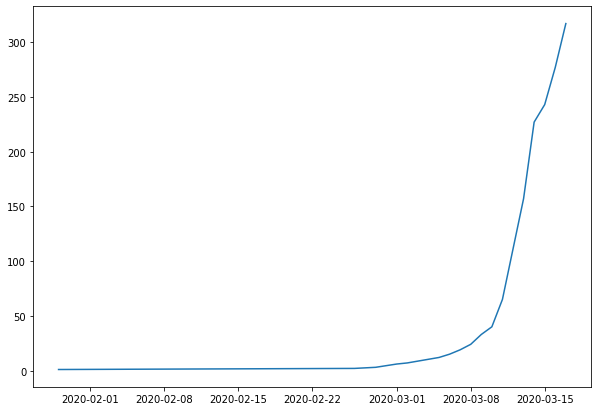

In [653]:
plt.figure(figsize=(10, 7))
plt.plot(finland_total.date, finland_total.id.cumsum())
plt.show()

In [535]:
confirmed_uusima = confirmed_finland[confirmed_finland.healthCareDistrict.isin(['HUS'])]
total_uusima = confirmed_uusima.groupby(['date'], as_index=False)['id'].count()

In [654]:
total_uusima.tail()

,date,id
12,2020-03-13,17
13,2020-03-14,48
14,2020-03-15,10
15,2020-03-16,21
16,2020-03-17,32


In [655]:
total_uusima.id.cumsum().tail()

12     69
13    117
14    127
15    148
16    180
Name: id, dtype: int64

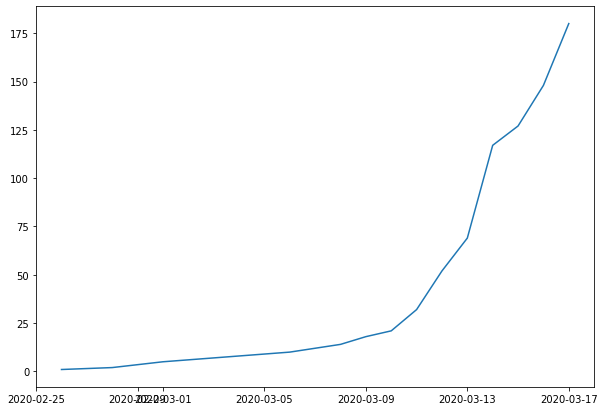

In [656]:
plt.figure(figsize=(10, 7))
plt.plot(total_uusima.date, total_uusima.id.cumsum())
plt.show()

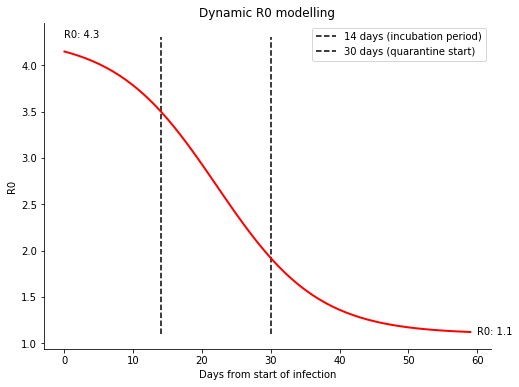

In [696]:
max_R0 = 4.3
min_R0 = 1.1

dynamic_R0 = expit(np.linspace(-5, 3, num=60))[::-1]
dynamic_R0 = dynamic_R0 * (max_R0 - min_R0) + min_R0
dynamic_R0 = np.concatenate((dynamic_R0, np.repeat(dynamic_R0[-1], 400-len(dynamic_R0))))

plt.figure(figsize=(8, 6))
plt.plot(dynamic_R0[:60], linewidth=2, color='red')
plt.title("Dynamic R0 modelling")
plt.text(0, max_R0, f"R0: {max_R0}")
plt.text(60, min_R0, f"R0: {min_R0}")
plt.vlines(14, min_R0, max_R0, label='14 days (incubation period)', linestyles='dashed')
plt.vlines(30, min_R0, max_R0, label='30 days (quarantine start)', linestyles='dashed')
plt.ylabel("R0")
plt.xlabel("Days from start of infection")
plt.legend()

sns.despine(top=True, right=True, left=False, bottom=False)

In [684]:
# sir = SIR(N=1304851, I0=1/0.05, beta=dynamic_R0 * 0.0576 * 2,  gamma=0.0576*2, days=150)
# S, I, R = sir.run()
# sir.plot_results(S, I, R)

In [685]:
# plt.figure(figsize=(10, 7))
# plt.plot(total_uusima.id.cumsum().values, label='actual reported')
# plt.plot(I[:20]/20, label='model')
# plt.title("Uusima region")
# plt.xlabel("Days from start of infection")
# plt.ylabel("Estimated reported number of cases")
# plt.legend()
# plt.grid()

In [556]:
total_uusima.id.cumsum().values

array([  1,   2,   5,   6,   9,  10,  12,  14,  18,  21,  32,  52,  69,
       117, 127, 148, 180])

In [557]:
def calculate_dynamic_R0(max_R0, min_R0, reaction_days, simulation_days):    
    dynamic_R0 = expit(np.linspace(-5, 3, num=reaction_days))[::-1]
    dynamic_R0 = dynamic_R0 * (max_R0 - min_R0) + min_R0
    dynamic_R0 = np.concatenate((dynamic_R0, np.repeat(dynamic_R0[-1], simulation_days)))
    return beta

In [558]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error

In [657]:
def loss(sir_params, actual_data):
    
    max_R0, min_R0, reaction_days, gamma = sir_params
    
    dynamic_R0 = calculate_dynamic_R0(max_R0, min_R0, int(reaction_days), len(actual_data))
    
    sir = SIR(N=1304851, I0=1/0.05, beta=dynamic_R0 * gamma, gamma=gamma, days=len(actual_data))
    S, I, R = sir.run()
    
    return mean_absolute_error(I/20, actual_data)#np.mean(np.square(I/10-actual_data))

In [658]:
loss([6, 1, 60, 0.01], total_uusima.id.cumsum().values)

46.927530989119006

In [659]:
from scipy.optimize import minimize

In [660]:
%%time
max_R0 = 0
min_R0 = 0
reaction_days=0
gamma = 10

res = minimize(
    loss, 
    x0=[max_R0, min_R0, reaction_days, gamma],
    args=(total_uusima.id.cumsum().values),
    #L-BFGS-B, TNC, SLSQP
    method="SLSQP",
    bounds=((2.1, 5), (1., 2.1), (15, 100), (0.0576, 0.0576*4))
)

print(res)

     fun: 6.876168236894927
     jac: array([  0.        ,   0.        ,   0.        , 244.25697666])
 message: 'Optimization terminated successfully.'
    nfev: 51
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 2.10000003,  1.        , 15.        ,  0.07360339])
CPU times: user 687 ms, sys: 0 ns, total: 687 ms
Wall time: 723 ms


In [661]:
import seaborn as sns

2.100000034333633 1.0000000000000002 15.0 0.07360338697471519


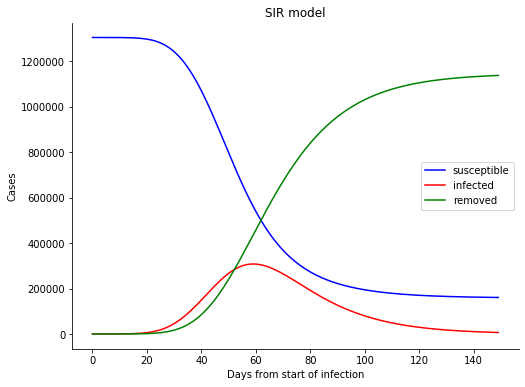

In [682]:
max_R0, min_R0, reaction_days, gamma = res.x
print(max_R0, min_R0, reaction_days, gamma)

sir = SIR(
    N=1304851, I0=1/0.1, beta=calculate_dynamic_R0(max_R0, min_R0, int(reaction_days), 300)*gamma, 
    gamma=gamma, days=150)
S, I, R = sir.run()

plt.figure(figsize=(8, 6))
plt.title("SIR model")
plt.plot(S, color='b', label='susceptible')
plt.plot(I, color='r', label='infected')
plt.plot(R, color='g', label='removed')
plt.legend()
plt.xlabel("Days from start of infection")
plt.ylabel("Cases")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

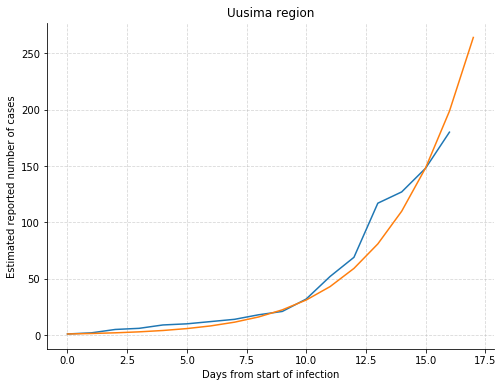

In [683]:
plt.figure(figsize=(8, 6))
plt.plot(total_uusima.id.cumsum().values)
plt.plot(I[:18]/10)
plt.title("Uusima region")
plt.xlabel("Days from start of infection")
plt.ylabel("Estimated reported number of cases")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(alpha=0.5, linestyle='dashed')